In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize

In [ ]:
# Define AlexNet From Scratch
class AlexNet(nn.Module):
    def __init__(self, num_classes):  
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [3]:
# Dataset Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet vals
])

train_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/train", transform=transform)
val_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/validation", transform=transform)
test_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 15  
model = AlexNet(num_classes=num_classes).to(device)

In [5]:
# CEL and AdaGrad
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training and Validation Loop
num_epochs = 30
metrics = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    metrics["train_loss"].append(running_loss / len(train_loader))
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["val_accuracy"].append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {correct / total:.4f}")

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30, Train Loss: 2.5925, Val Loss: 2.4303, Val Accuracy: 0.1654
Epoch 2/30, Train Loss: 2.3748, Val Loss: 2.3370, Val Accuracy: 0.1891
Epoch 3/30, Train Loss: 2.3584, Val Loss: 2.3081, Val Accuracy: 0.1954
Epoch 4/30, Train Loss: 2.3223, Val Loss: 2.3549, Val Accuracy: 0.1919
Epoch 5/30, Train Loss: 2.2610, Val Loss: 2.2520, Val Accuracy: 0.2463
Epoch 6/30, Train Loss: 2.2088, Val Loss: 2.2008, Val Accuracy: 0.2331
Epoch 7/30, Train Loss: 2.1807, Val Loss: 2.1550, Val Accuracy: 0.2631
Epoch 8/30, Train Loss: 2.1204, Val Loss: 2.1300, Val Accuracy: 0.2673
Epoch 9/30, Train Loss: 2.1154, Val Loss: 2.1626, Val Accuracy: 0.2708
Epoch 10/30, Train Loss: 2.0858, Val Loss: 2.1109, Val Accuracy: 0.2826
Epoch 11/30, Train Loss: 2.0015, Val Loss: 2.1126, Val Accuracy: 0.2917
Epoch 12/30, Train Loss: 1.9588, Val Loss: 2.0977, Val Accuracy: 0.2889
Epoch 13/30, Train Loss: 1.9120, Val Loss: 2.1333, Val Accuracy: 0.2861
Epoch 14/30, Train Loss: 1.8526, Val Loss: 2.1796, Val Accuracy: 0.2791
E

In [7]:
# Test
model.eval()
test_labels = []
test_preds = []
test_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_labels.extend(labels.cpu().numpy()) # Actual labels
        test_preds.extend(preds.cpu().numpy())   # Predicted labels
        test_probs.extend(probs.cpu().numpy())   # Probability distributions

# Convert test labels to one-hot encoding for mAP computation
test_labels_one_hot = label_binarize(test_labels, classes=range(num_classes))

# Compute Metrics
precision = precision_score(test_labels, test_preds, average="macro")
recall = recall_score(test_labels, test_preds, average="macro")
f1 = f1_score(test_labels, test_preds, average="macro")
map_score = average_precision_score(test_labels_one_hot, test_probs, average="macro")

print(f"\nTest Metrics:\n"
      f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1-Score: {f1:.4f}\n"
      f"mAP: {map_score:.4f}")


Test Metrics:
Precision: 0.3299
Recall: 0.2925
F1-Score: 0.2830
mAP: 0.2654


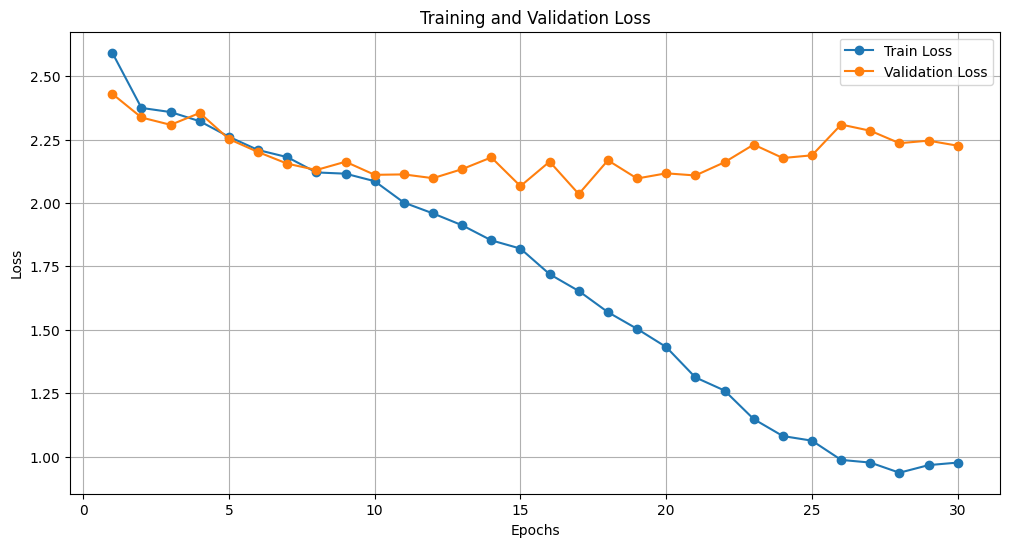

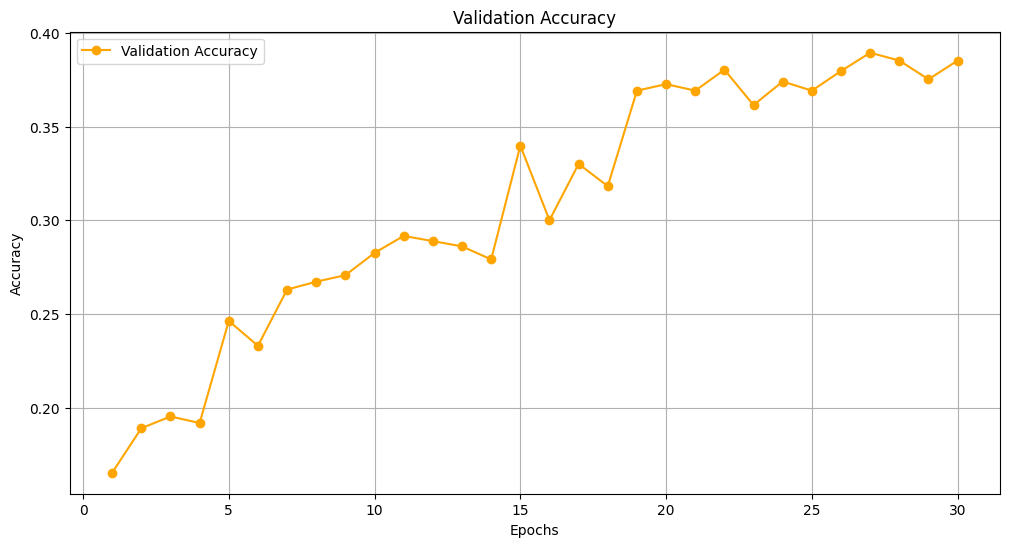

In [35]:
# Plot Loss

metrics["train_loss"]
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1 ), metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1 ), metrics["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), metrics["val_accuracy"], label="Validation Accuracy", marker='o', color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()